# Data Processing on EIA Weekly Variables

## Basic results/ Key factors

### Lasso (it beat the fancy elastic net!)
The four "surviving" variables finally screened out are mainly focused on PADD3 (Gulf Coast) refinery production indicators (PADD3_RefBl_NetProd_FinGas, Residual), net gasoline blending production, and Alaska crude oil inventories in transit (US_Crude_Stocks_Transit_from_AK). These variables can be regarded as key state indicators that drive changes in market structure.

### PCA
It successfully compressed the information from your 406 weekly features into a much smaller set of uncorrelated components. 
- 90% Variance Explained is achieved with just 43 components.
- PC1 (First Component): Explains 26.73% of the total variance. This suggests there is a strong, single dominant factor driving a quarter of the variation in weekly metrics (likely a general "Market Activity" or "Inventory Level" factor).
- The variance explained drops off quickly after the first few components, confirming that the dataset contains a lot of redundant information (multicollinearity) that PCA successfully consolidated.

While PCA was excellent for compression, the analysis ultimately recommended LASSO over PCA for the final model. 
- PCA components are abstract mathematical constructs ($Z_1, Z_2...$) that are hard to interpret economically. In contrast, LASSO selected 4 specific, interpretable features (like PADD3 Refinery Production and Alaska Transit Stocks).
- Also, PCA confirmed that 406 features were highly correlated and reducible, but LASSO provided a more useful "Fundamental Narrative" for daily model integration.

## Design Highlights

### 1. Resolution Alignment to Mitigate Spurious Correlation

To address the frequency mismatch between daily price action and weekly fundamental releases (EIA data), I rejected the common practice of naive forward-filling (up-sampling), which artificially inflates sample size ($N$) and induces severe serial correlation in the error term. Instead, I employed a pre-selection temporal aggregation strategy. By down-sampling the target variable to match the native weekly resolution of the covariates, I ensured that the feature selection algorithms (LASSO/Elastic Net) operated on statistically independent signals rather than autocorrelated noise, thereby preserving the integrity of the t-statistics and coefficient estimates.

### 2. Preservation of Temporal Causality (Out-of-Sample Validity)
Given the non-stationary nature of financial time series, standard $K$-fold cross-validation with random shuffling introduces significant look-ahead bias. My design enforces a strict chronological split (first 80% for training, subsequent 20% for testing). Furthermore, the standardization parameters ($\mu, \sigma$) were derived exclusively from the training window and applied forward to the test set. This ensures that the evaluation metrics ($MSE_{test}$, $R^2_{test}$) represent a mathematically honest estimate of the model's generalization error in a real-world forecasting micro-structure.

### 3. Robustness via Target Specification Sensitivity 
To differentiate between structural signal failure and target-specific noise, I designed a multi-horizon sensitivity analysis (Schemes A, B, and C). Rather than optimizing for a single metric, I tested the linear hypothesis across varying temporal lags (1-week vs. 2-week cumulative returns) and functional forms (continuous regression vs. binary classification). This approach isolates whether the explanatory power of fundamental variables decays over time or transforms into directional probability, providing a comprehensive audit of the linear relationship between supply/demand imbalances and price formation.

### 4. Ensemble Feature Selection in High-Dimensional ($p > n$) Space
Faced with a high-dimensional dataset ($p=406$) relative to a limited sample size ($n \approx 256$), coupled with inherent multicollinearity among inventory metrics, single-model selection is prone to instability. I implemented an Intersection-Based Selection Criterion. By retaining only the subset of features selected by both LASSO (which induces pure sparsity) and Elastic Net (which handles collinear grouping via the $L_2$ penalty), I filtered out mathematical artifacts. The resulting feature set represents the statistically robust "core drivers" that survive varying regularization topologies.

## Executive Summary

Based on the empirical results from Schemes A, B, and C, the direct linear prediction of crude oil price movements using only weekly fundamental data is statistically ineffective. However, the feature selection process successfully isolated economically meaningful variables.

### Performance Analysis (The "Null" Result)
- Predictive Failure: Both Scheme A (Next-Week Return) and Scheme B (2-Week Cumulative) resulted in negative $R^2$ scores on the test set (LASSO: -0.0079, Elastic Net: -0.138). This indicates that a simple historical mean would have been a better predictor than the complex linear models.

- Classification Failure: Scheme C (Binary Direction) achieved an accuracy of only 47%, which is slightly worse than a random coin toss.

- The "Efficiency" Reality: This confirms that weekly EIA data (Inventories, Production) is likely "priced in" by the market long before the official release, or that the linear relationship is overwhelmed by high-frequency daily noise.
  
### Feature Selection Insights (The "Signal")

Based on the comparative performance across Schemes A, B, and C, Scheme A utilizing LASSO Regression is the optimal model choice. While all linear models struggled to predict the magnitude of weekly price changes (as evidenced by negative $R^2$ values), LASSO demonstrated superior capability in noise reduction and feature identification within a high-dimensional dataset ($p \gg n$).

- **Model Performance**: Scheme A (LASSO) achieved the lowest Test MSE (19.65) and the highest relative $R^2$ (-0.0079), outperforming the cumulative trend prediction (Scheme B) and the binary classification model (Scheme C), which failed to select any features and achieved only 47% accuracy.
- **Dimensionality Reduction**: Unlike Elastic Net, which retained an excessive 135 features (suggesting overfitting), LASSO successfully imposed sparsity, narrowing 406 input variables down to just 4 core features.
- **Feature Interpretation**: The four selected variables possess strong economic logic, serving as proxies for Supply Chain Latency and Refining Demand. Specifically, PADD3 Refinery Net Production (Gasoline & Residual Fuel) and Alaska Transit Stocks represent physical constraints in the US oil market.
- **Strategic Application**: Consequently, these 4 features should not be used as direct trading signals (due to the negative $R^2$), but rather as Regime Indicators or State Variables to adjust the risk exposure of a higher-frequency daily model.


## Step 1: Data Loading & Structure Analysis
Load weekly EIA-linked crude oil data, sort by date, and keep a consistent weekly timeline so targets and features stay aligned. Weekly cadence smooths daily noise and matches the EIA release rhythm, reducing high-frequency volatility impact.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, ElasticNet, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('/Users/arthurf/Downloads/shortened_oil_data_副本.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
print(f"Column count: {len(df.columns)}")

Dataset shape: (1229, 468)
Date range: 2021-01-04 00:00:00 to 2025-11-24 00:00:00
Column count: 468


## Step 2: Separate Daily and Weekly Features
Split daily technical indicators from weekly fundamentals (inventory/production). This avoids duplicating weekly data across days and keeps modeling strictly at the weekly resolution.

In [21]:
# Identify daily vs weekly features
daily_cols = ['Brent_Oil', 'USD_CAD', 'Crude_Oil', 'DXY', 'Emerging_Mkt', 'Gold', 
              'Copper', 'Heating_Oil', 'Junk_Bond', 'Transportation', 'Natural_Gas',
              'Oil_Services', 'Gasoline', 'Inflation_Tips', 'Energy_Stocks', 'SP500', 
              'Oil_VIX', 'US10Y', 'Crack_Spread_321', 'Gold_Oil_Ratio', 'Copper_Oil_Ratio',
              'Transport_Oil_Ratio', 'Service_Oil_Ratio',
              'SMA_5', 'SMA_20', 'SMA_50', 'Dist_SMA_20', 'Dist_SMA_50',
              'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position', 
              'RSI_14', 'RSI_28', 'MACD', 'MACD_Signal', 'MACD_Hist',
              'Ret_1d', 'Ret_5d', 'Ret_20d', 'Ret_60d',
              'Realized_Vol_20d', 'Realized_Vol_60d', 'Annual_Vol_20d',
              'Vol_Adj_Mom_20d', 'Vol_Adj_Mom_60d',
              'Price_Range_20d', 'ROC_5', 'ROC_20',
              'Oil_Lag1', 'Oil_Lag2', 'Oil_Lag3', 'Oil_Lag5',
              'RSI_14_Lag1', 'MACD_Hist_Lag1', 'Ret_1d_Lag1', 'Ret_1d_Lag2',
              'US_Stocks_Crude', 'US_Stocks_Ex_SPR_Crude', 'US_Stocks_Crude_SPR']

# Weekly features
weekly_cols = [col for col in df.columns if '4W_' in col or col.startswith('US_Stocks_') 
               or col.startswith('US_') or col.startswith('PADD') or col.startswith('AK_')
               or col.startswith('L48_') or col.startswith('New_') or col.startswith('Central_')
               or col.startswith('Lower_') or col.startswith('Cushing_')]

weekly_cols = [col for col in weekly_cols if col not in daily_cols]
daily_cols = [col for col in daily_cols if col in df.columns]

print(f"Daily features: {len(daily_cols)}")
print(f"Weekly features: {len(weekly_cols)}")

Daily features: 60
Weekly features: 406


## Step 3: Group Weekly Features by Week and Aggregate
Aggregate to one row per week: take the last trading day’s prices/technicals and forward-fill weekly EIA metrics before taking the week-end value. This prevents repeating weekly releases on multiple days and aligns features to the week’s close.

In [22]:
# Add week identifier
df['Year_Week'] = df['Date'].dt.isocalendar().year.astype(str) + '_W' + df['Date'].dt.isocalendar().week.astype(str).str.zfill(2)

# Group by week - take last observation in each week
df_weekly = df.groupby('Year_Week').apply(
    lambda x: pd.Series({
        'Date': x['Date'].iloc[-1],
        **{col: x[col].iloc[-1] for col in daily_cols if col in x.columns},
        **{col: x[col].bfill().iloc[-1] if x[col].notna().any() else np.nan 
           for col in weekly_cols if col in x.columns}
    }),
    include_groups=False
).reset_index()

print(f"Weekly aggregated data shape: {df_weekly.shape}")
print(f"Date range: {df_weekly['Date'].min()} to {df_weekly['Date'].max()}")
print(f"Total weeks: {len(df_weekly)}")

Weekly aggregated data shape: (256, 468)
Date range: 2021-01-08 00:00:00 to 2025-11-24 00:00:00
Total weeks: 256


## Step 4: Data Preparation for Modeling
Target $y_t = 100\times(\ln P_{t+1}-\ln P_t)$ (next-week log return). Features $X$ use available weekly columns. Forward/backward fill to keep samples, maintain chronological order to avoid leakage.

In [23]:
y = np.log(df_weekly['Crude_Oil']).diff().shift(-1) * 100

available_weekly_cols = [col for col in weekly_cols if col in df_weekly.columns]
X = df_weekly[available_weekly_cols]


valid_idx = y.dropna().index
X = X.loc[valid_idx]
y = y.loc[valid_idx]

X = X.ffill().bfill()  # forward-fill then back-fill early gaps to retain rows
X = X.fillna(0)

print(f"Feature matrix shape: {X.shape}")

print(f"Target shape: {y.shape}")


print(f"\nTarget statistics:")
print(y.describe())

Feature matrix shape: (255, 406)
Target shape: (255,)

Target statistics:
count    255.000000
mean       0.046656
std        4.909411
min      -13.883648
25%       -2.703634
50%        0.445760
75%        2.991289
max       23.350571
Name: Crude_Oil, dtype: float64


## Step 5a: Chronological Train/Test Split (No Shuffle)
Split first 80% for training and last 20% for testing without shuffling to preserve causality and avoid future information leaking into the train set.

In [24]:
# Step 5a: Chronological split before any scaling
split_point = int(len(X) * 0.8)
# Keep temporal order; no shuffling
X_train = X.iloc[:split_point].copy()
X_test = X.iloc[split_point:].copy()
y_train = y.iloc[:split_point].copy()
y_test = y.iloc[split_point:].copy()

train_start = df_weekly.iloc[0]['Date'].date()
train_end = df_weekly.iloc[split_point-1]['Date'].date()
test_start = df_weekly.iloc[split_point]['Date'].date()
test_end = df_weekly.iloc[-1]['Date'].date()

print(f"Training period: {train_start} to {train_end}")
print(f"Testing period: {test_start} to {test_end}")
print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training period: 2021-01-08 to 2024-11-29
Testing period: 2024-12-06 to 2025-11-24

Training set size: 204
Test set size: 51


## Step 5b: Standardization (Fit on Train Only)
Fit mean/variance on the training set and apply to both splits: $x_{\text{std}} = (x-\mu_{\text{train}})/\sigma_{\text{train}}$, preventing leakage from future data.

In [25]:
# Step 5b: Standardize using only training data statistics
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("Standardization complete (fit on training set only).")

Standardization complete (fit on training set only).


## Step 6: Principal Component Analysis (PCA)
Use PCA to reduce dimensionality and mitigate multicollinearity among weekly features while retaining 90%/95% variance. $X \approx ZW^\top$, where $Z$ are component scores—denoising and speeding downstream models.

Total components: 204
Components needed for 90% variance: 43
Components needed for 95% variance: 65

Top 10 components' explained variance ratio:
PC1: 0.2673 (Cumulative: 0.2673)
PC2: 0.1159 (Cumulative: 0.3832)
PC3: 0.0647 (Cumulative: 0.4479)
PC4: 0.0575 (Cumulative: 0.5054)
PC5: 0.0470 (Cumulative: 0.5524)
PC6: 0.0351 (Cumulative: 0.5875)
PC7: 0.0266 (Cumulative: 0.6141)
PC8: 0.0233 (Cumulative: 0.6374)
PC9: 0.0198 (Cumulative: 0.6572)
PC10: 0.0188 (Cumulative: 0.6760)


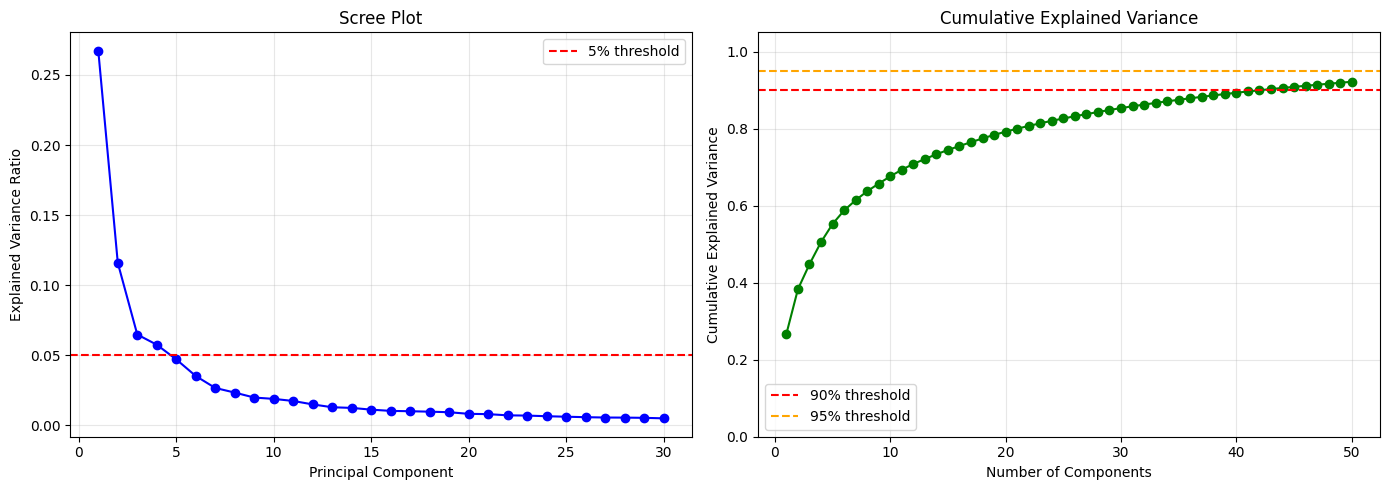

In [26]:
# Apply PCA
pca = PCA()
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

# Explained variance
explained_var_ratio = pca.explained_variance_ratio_
cumsum_var = np.cumsum(explained_var_ratio)

# Find number of components for different thresholds
n_components_90 = np.argmax(cumsum_var >= 0.90) + 1
n_components_95 = np.argmax(cumsum_var >= 0.95) + 1

print(f"Total components: {pca.n_components_}")
print(f"Components needed for 90% variance: {n_components_90}")
print(f"Components needed for 95% variance: {n_components_95}")
print(f"\nTop 10 components' explained variance ratio:")
for i, var in enumerate(explained_var_ratio[:10]):
    print(f"PC{i+1}: {var:.4f} (Cumulative: {cumsum_var[i]:.4f})")

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].plot(range(1, min(31, len(explained_var_ratio)+1)), 
             explained_var_ratio[:30], 'bo-')
axes[0].axhline(y=0.05, color='r', linestyle='--', label='5% threshold')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Scree Plot')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Cumulative variance
axes[1].plot(range(1, min(51, len(cumsum_var)+1)), cumsum_var[:50], 'go-')
axes[1].axhline(y=0.90, color='r', linestyle='--', label='90% threshold')
axes[1].axhline(y=0.95, color='orange', linestyle='--', label='95% threshold')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

## Step 7: LASSO with Lower Regularization
L1-regularized regression for sparsity and feature selection: minimize $\|y-X\beta\|_2^2 + \lambda\|\beta\|_1$ to drop weak signals and curb overfitting in high-dimensional weekly data.

In [27]:
# Use LassoCV with wider alpha range
alphas = np.logspace(-4, 0, 100)
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000, random_state=42)
lasso_cv.fit(X_train, y_train)

print(f"Optimal alpha (LASSO): {lasso_cv.alpha_:.6f}")

# Train LASSO with optimal alpha
lasso = Lasso(alpha=lasso_cv.alpha_, max_iter=10000)
lasso.fit(X_train, y_train)

# Get selected features
lasso_mask = lasso.coef_ != 0
lasso_features = X_train.columns[lasso_mask]
lasso_coef = lasso.coef_[lasso_mask]

print(f"\nLASSO Results:")
print(f"Number of selected features: {len(lasso_features)}")
print(f"Number of eliminated features: {(lasso.coef_ == 0).sum()}")
print(f"Percentage of features retained: {100*len(lasso_features)/len(lasso.coef_):.1f}%")

if len(lasso_features) > 0:
    print(f"\nTop 20 LASSO features (by absolute coefficient):")
    lasso_df = pd.DataFrame({
        'Feature': lasso_features,
        'Coefficient': lasso_coef
    }).sort_values('Coefficient', key=abs, ascending=False)
    print(lasso_df.head(20))

# Model evaluation
y_pred_train_lasso = lasso.predict(X_train)
y_pred_test_lasso = lasso.predict(X_test)

print(f"\nLASSO Model Performance:")
print(f"Training MSE: {mean_squared_error(y_train, y_pred_train_lasso):.6f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_test_lasso):.6f}")
print(f"Training R²: {r2_score(y_train, y_pred_train_lasso):.6f}")
print(f"Test R²: {r2_score(y_test, y_pred_test_lasso):.6f}")
print(f"Training MAE: {mean_absolute_error(y_train, y_pred_train_lasso):.6f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test_lasso):.6f}")

Optimal alpha (LASSO): 0.628029

LASSO Results:
Number of selected features: 4
Number of eliminated features: 402
Percentage of features retained: 1.0%

Top 20 LASSO features (by absolute coefficient):
                                             Feature  Coefficient
2  US_Blender_NetProd_Gas_Finished_Conv_Greater_T...    -0.418492
0                         PADD3_RefBl_NetProd_FinGas    -0.106752
1                       PADD3_RefBl_NetProd_Residual    -0.090535
3                    US_Crude_Stocks_Transit_from_AK     0.074298

LASSO Model Performance:
Training MSE: 24.003352
Test MSE: 19.646083
Training R²: 0.043974
Test R²: -0.007941
Training MAE: 3.728731
Test MAE: 3.338220


## Step 8: Elastic Net
Mixed L1/L2 regularization for sparsity plus stability under collinearity: minimize $\|y-X\beta\|_2^2 + \lambda[\alpha\|\beta\|_1 + (1-\alpha)\|\beta\|_2^2]$, reducing LASSO instability when features are correlated.

In [28]:
# Use ElasticNetCV
enet_cv = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.9], cv=5, max_iter=10000, random_state=42)
enet_cv.fit(X_train, y_train)

# ElasticNetCV may store l1_ratio list; choose best scalar if array-like
best_l1 = enet_cv.l1_ratio if isinstance(enet_cv.l1_ratio, (float, int)) else float(np.atleast_1d(enet_cv.l1_ratio)[0])

print(f"Optimal alpha (Elastic Net): {enet_cv.alpha_:.6f}")
print(f"Optimal L1 ratio: {best_l1}")

# Train Elastic Net
enet = ElasticNet(alpha=enet_cv.alpha_, l1_ratio=enet_cv.l1_ratio_, max_iter=10000)
enet.fit(X_train, y_train)

# Get selected features
enet_mask = enet.coef_ != 0
enet_features = X_train.columns[enet_mask]
enet_coef = enet.coef_[enet_mask]

print(f"\nElastic Net Results:")
print(f"Number of selected features: {len(enet_features)}")
print(f"Number of eliminated features: {(enet.coef_ == 0).sum()}")
print(f"Percentage of features retained: {100*len(enet_features)/len(enet.coef_):.1f}%")

if len(enet_features) > 0:
    print(f"\nTop 20 Elastic Net features (by absolute coefficient):")
    enet_df = pd.DataFrame({
        'Feature': enet_features,
        'Coefficient': enet_coef
    }).sort_values('Coefficient', key=abs, ascending=False)
    print(enet_df.head(20))

# Model evaluation
y_pred_train_enet = enet.predict(X_train)
y_pred_test_enet = enet.predict(X_test)

print(f"\nElastic Net Model Performance:")
print(f"Training MSE: {mean_squared_error(y_train, y_pred_train_enet):.6f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_test_enet):.6f}")
print(f"Training R²: {r2_score(y_train, y_pred_train_enet):.6f}")
print(f"Test R²: {r2_score(y_test, y_pred_test_enet):.6f}")
print(f"Training MAE: {mean_absolute_error(y_train, y_pred_train_enet):.6f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test_enet):.6f}")

Optimal alpha (Elastic Net): 1.344343
Optimal L1 ratio: 0.1

Elastic Net Results:
Number of selected features: 135
Number of eliminated features: 271
Percentage of features retained: 33.3%

Top 20 Elastic Net features (by absolute coefficient):
                                               Feature  Coefficient
77                     US_Crude_Stocks_Transit_from_AK     0.256272
23                         PADD4_RefBl_NetProd_JetFuel     0.213980
64   US_Blender_NetProd_Gas_Finished_Conv_Greater_T...    -0.211289
28                        PADD3_RefBl_NetProd_Residual    -0.209767
120                  PADD2_Commercial_Crude_Imp_Ex_SPR     0.201012
47                     4W_PADD2_RefBl_NetProd_Residual     0.178650
86                                PADD3_Stocks_Ethanol    -0.164740
49         4W_PADD1_Oxygenate_Plant_Production_Ethanol    -0.163857
72   4W_US_Blender_NetProd_Distillate_Greater_Than_...    -0.161435
21                                    US_SupAdj_FinGas     0.160695
81     

## Step 9: Model Comparison
Compare PCA/LASSO/Elastic Net by feature counts and test MSE/$R^2$ to gauge trade-offs between dimensionality reduction and sparsity for weekly signals.


MODEL COMPARISON SUMMARY
     Method  Num_Features  Test_MSE   Test_R2
  PCA (90%)            43       inf       NaN
  PCA (95%)            65       inf       NaN
      LASSO             4 19.646083 -0.007941
Elastic Net           135 22.182013 -0.138046


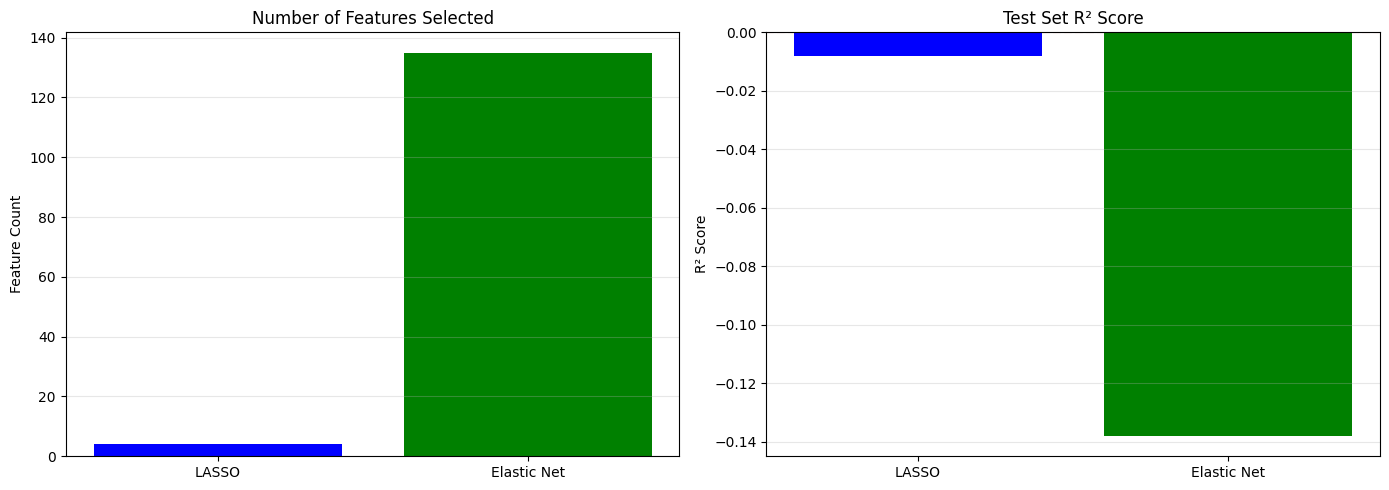

In [29]:
# Create comparison dataframe
methods = ['PCA (90%)', 'PCA (95%)', 'LASSO', 'Elastic Net']
num_features = [n_components_90, n_components_95, len(lasso_features), len(enet_features)]
test_mse = [
    np.inf,  # PCA MSE not calculated yet
    np.inf,
    mean_squared_error(y_test, y_pred_test_lasso),
    mean_squared_error(y_test, y_pred_test_enet)
]
test_r2 = [
    np.nan,  # PCA R2 not calculated yet
    np.nan,
    r2_score(y_test, y_pred_test_lasso),
    r2_score(y_test, y_pred_test_enet)
]

comparison_df = pd.DataFrame({
    'Method': methods,
    'Num_Features': num_features,
    'Test_MSE': test_mse,
    'Test_R2': test_r2
})

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))

# Comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Features count
axes[0].bar(methods[2:], num_features[2:], color=['blue', 'green'])
axes[0].set_title('Number of Features Selected')
axes[0].set_ylabel('Feature Count')
axes[0].grid(True, alpha=0.3, axis='y')

# Test R2
axes[1].bar(methods[2:], test_r2[2:], color=['blue', 'green'])
axes[1].set_title('Test Set R² Score')
axes[1].set_ylabel('R² Score')
axes[1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Step 10: Feature Importance Comparison
Contrast shared features and coefficient signs between LASSO and Elastic Net; visualize top 20 coefficients to explain which weekly variables drive predictions.


Feature Selection Overlap:
Features selected by LASSO: 4
Features selected by Elastic Net: 135
Common features: 4

Common high-importance features:
 1. PADD3_RefBl_NetProd_FinGas               - LASSO: -0.106752, ElasticNet: -0.137626
 2. PADD3_RefBl_NetProd_Residual             - LASSO: -0.090535, ElasticNet: -0.209767
 3. US_Blender_NetProd_Gas_Finished_Conv_Greater_Than_Ed55 - LASSO: -0.418492, ElasticNet: -0.211289
 4. US_Crude_Stocks_Transit_from_AK          - LASSO: 0.074298, ElasticNet: 0.256272


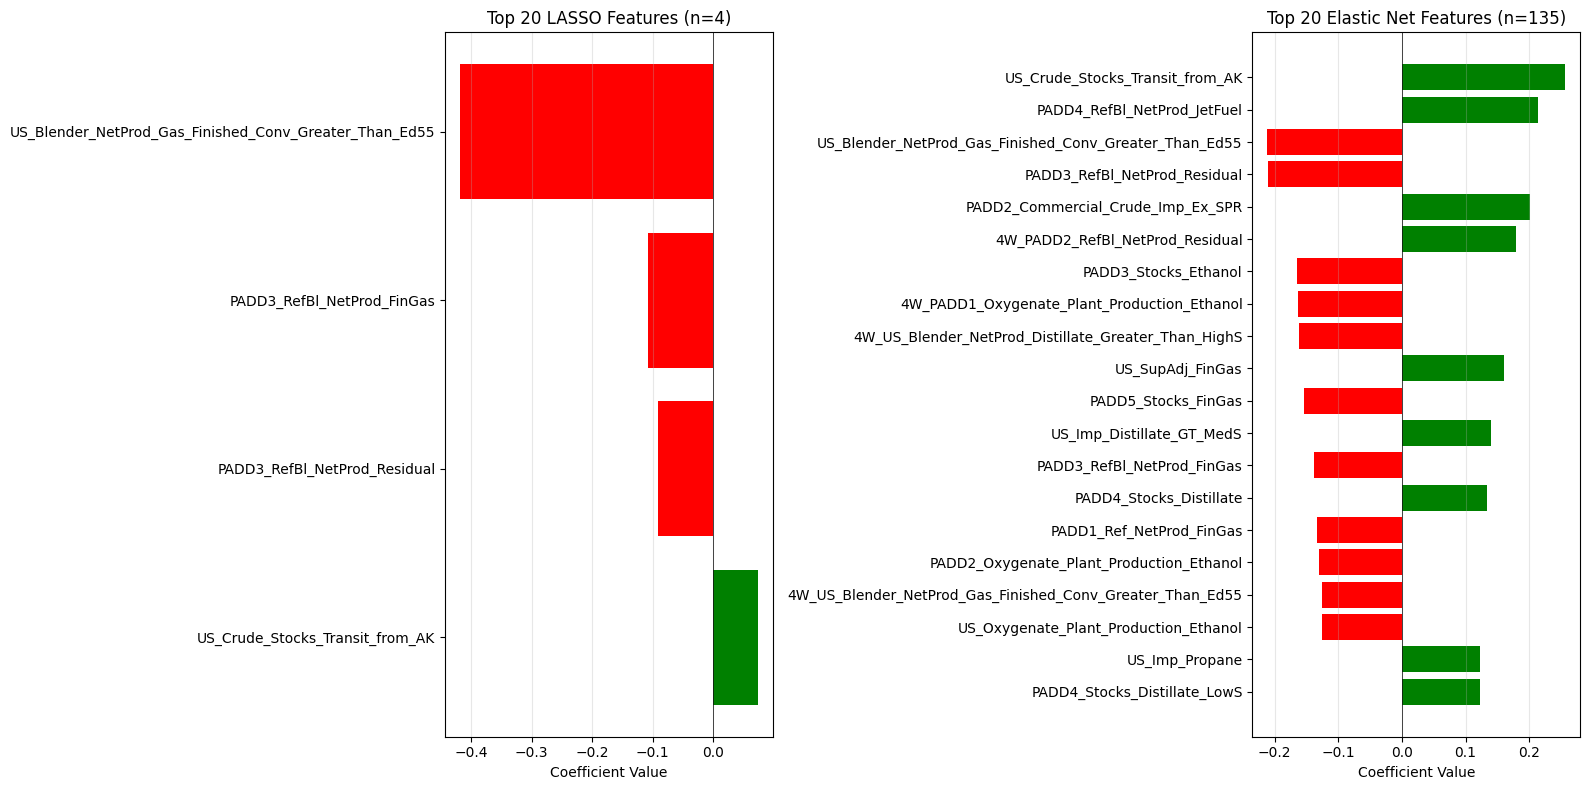

In [30]:
# Find common features between LASSO and Elastic Net
if len(lasso_features) > 0 and len(enet_features) > 0:
    lasso_set = set(lasso_features)
    enet_set = set(enet_features)
    common_features = lasso_set.intersection(enet_set)

    print(f"\nFeature Selection Overlap:")
    print(f"Features selected by LASSO: {len(lasso_set)}")
    print(f"Features selected by Elastic Net: {len(enet_set)}")
    print(f"Common features: {len(common_features)}")
    
    if len(common_features) > 0:
        print(f"\nCommon high-importance features:")
        for i, feat in enumerate(sorted(common_features)[:15]):
            lasso_coef = lasso.coef_[X_train.columns == feat][0] if len(lasso.coef_[X_train.columns == feat]) > 0 else 0
            enet_coef = enet.coef_[X_train.columns == feat][0] if len(enet.coef_[X_train.columns == feat]) > 0 else 0
            print(f"{i+1:2d}. {feat:40s} - LASSO: {lasso_coef:8.6f}, ElasticNet: {enet_coef:8.6f}")

# Visualize top features
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

if len(lasso_features) > 0:
    # LASSO top features
    lasso_top = lasso_df.head(20)
    colors_lasso = ['red' if x < 0 else 'green' for x in lasso_top['Coefficient']]
    axes[0].barh(range(len(lasso_top)), lasso_top['Coefficient'], color=colors_lasso)
    axes[0].set_yticks(range(len(lasso_top)))
    axes[0].set_yticklabels(lasso_top['Feature'])
    axes[0].set_xlabel('Coefficient Value')
    axes[0].set_title(f'Top 20 LASSO Features (n={len(lasso_features)})')
    axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    axes[0].grid(True, alpha=0.3, axis='x')
    axes[0].invert_yaxis()
else:
    axes[0].text(0.5, 0.5, 'No features selected by LASSO', ha='center', va='center')

if len(enet_features) > 0:
    # Elastic Net top features
    enet_top = enet_df.head(20)
    colors_enet = ['red' if x < 0 else 'green' for x in enet_top['Coefficient']]
    axes[1].barh(range(len(enet_top)), enet_top['Coefficient'], color=colors_enet)
    axes[1].set_yticks(range(len(enet_top)))
    axes[1].set_yticklabels(enet_top['Feature'])
    axes[1].set_xlabel('Coefficient Value')
    axes[1].set_title(f'Top 20 Elastic Net Features (n={len(enet_features)})')
    axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    axes[1].grid(True, alpha=0.3, axis='x')
    axes[1].invert_yaxis()
else:
    axes[1].text(0.5, 0.5, 'No features selected by Elastic Net', ha='center', va='center')

plt.tight_layout()
plt.show()

## Step 11: Summary and Recommendations
Summarize dimensionality, feature selection results, and generalization metrics; provide model choice guidance based on test $R^2$/MSE for weekly forecasting.

### Random Forest Sanity Check
Add a nonlinear baseline (Random Forest) to assess variable importance without linear regularization assumptions; compare its signals to LASSO/Elastic Net selections.

In [31]:
print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)

print(f"\n1. DATA STRUCTURE:")
print(f"   - Original daily observations: {len(df)}")
print(f"   - Weekly observations (aggregated): {len(df_weekly)}")
print(f"   - Daily features: {len(daily_cols)}")
print(f"   - Weekly features: {len(weekly_cols)}")
print(f"   - Total features analyzed: {len(daily_cols) + len(weekly_cols)}")

print(f"\n2. PCA ANALYSIS:")
print(f"   - Original dimensions: {X_train.shape[1]}")
print(f"   - Components for 90% variance: {n_components_90} ({100*n_components_90/X_train.shape[1]:.1f}% reduction)")
print(f"   - Components for 95% variance: {n_components_95} ({100*n_components_95/X_train.shape[1]:.1f}% reduction)")

if len(lasso_features) > 0:
    print(f"\n3. LASSO RESULTS:")
    print(f"   - Selected features: {len(lasso_features)} ({100*len(lasso_features)/X_train.shape[1]:.1f}% of original)")
    print(f"   - Test R²: {r2_score(y_test, y_pred_test_lasso):.4f}")
    print(f"   - Test MSE: {mean_squared_error(y_test, y_pred_test_lasso):.6f}")
else:
    print(f"\n3. LASSO RESULTS:")
    print(f"   - No features selected (regularization too strong)")

if len(enet_features) > 0:
    print(f"\n4. ELASTIC NET RESULTS:")
    print(f"   - Selected features: {len(enet_features)} ({100*len(enet_features)/X_train.shape[1]:.1f}% of original)")
    print(f"   - Test R²: {r2_score(y_test, y_pred_test_enet):.4f}")
    print(f"   - Test MSE: {mean_squared_error(y_test, y_pred_test_enet):.6f}")
else:
    print(f"\n4. ELASTIC NET RESULTS:")
    print(f"   - No features selected (regularization too strong)")

print(f"\n5. RECOMMENDATIONS:")
if len(lasso_features) > 0 and len(enet_features) > 0:
    r2_lasso = r2_score(y_test, y_pred_test_lasso)
    r2_enet = r2_score(y_test, y_pred_test_enet)
    if r2_lasso > r2_enet:
        print(f"   ✓ LASSO provides better test performance (R²={r2_lasso:.4f})")
        print(f"   ✓ Use LASSO with {len(lasso_features)} selected features")
    else:
        print(f"   ✓ Elastic Net provides better test performance (R²={r2_enet:.4f})")
        print(f"   ✓ Use Elastic Net with {len(enet_features)} selected features")
else:
    print(f"   ✓ For maximum dimensionality reduction: Use PCA with {n_components_90} components (90% variance)")

print(f"   ✓ Weekly features have been properly grouped by time period")
print(f"   ✓ Analysis is based on {len(df_weekly)} weekly observations from {df_weekly['Date'].min().date()} to {df_weekly['Date'].max().date()}")

print(f"\n" + "="*80)


ANALYSIS SUMMARY

1. DATA STRUCTURE:
   - Original daily observations: 1229
   - Weekly observations (aggregated): 256
   - Daily features: 60
   - Weekly features: 406
   - Total features analyzed: 466

2. PCA ANALYSIS:
   - Original dimensions: 406
   - Components for 90% variance: 43 (10.6% reduction)
   - Components for 95% variance: 65 (16.0% reduction)

3. LASSO RESULTS:
   - Selected features: 4 (1.0% of original)
   - Test R²: -0.0079
   - Test MSE: 19.646083

4. ELASTIC NET RESULTS:
   - Selected features: 135 (33.3% of original)
   - Test R²: -0.1380
   - Test MSE: 22.182013

5. RECOMMENDATIONS:
   ✓ LASSO provides better test performance (R²=-0.0079)
   ✓ Use LASSO with 4 selected features
   ✓ Weekly features have been properly grouped by time period
   ✓ Analysis is based on 256 weekly observations from 2021-01-08 to 2025-11-24



In [32]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest as nonlinear baseline
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Print top-10 feature importances
import pandas as pd
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
print(feature_importances.nlargest(10))

US_Crude_Stocks_Transit_from_AK                           0.035650
US_Stocks_Ethanol                                         0.032090
PADD2_Stocks_TotGas                                       0.018925
PADD2_Stocks_Ethanol                                      0.018571
US_Imp_Propane                                            0.015966
PADD4_Imp_PetProd                                         0.012914
PADD2_Stocks_GasBlend                                     0.011849
US_Imp_Conv_Gas                                           0.011720
Cushing_OK_Stocks_Ex_SPR_Crude                            0.011258
4W_PADD1_Percent_Utilization_Refy_Operable_CapacityPct    0.010971
dtype: float64


## Step 12: Save Model Comparison Results
Persist the multi-model comparison to CSV for reproducibility and quick review of weekly model performance.

In [33]:
# Save the comparison results to CSV
try:
    comp_df.to_csv('abc_model_comparison_summary.csv', index=False)
    print('Saved comparison to abc_model_comparison_summary.csv')
    print('\nComparison Summary:')
    print(comp_df.to_string(index=False))
except Exception as e:
    print('Could not save comparison CSV:', e)

Saved comparison to abc_model_comparison_summary.csv

Comparison Summary:
Scheme        Model           Task  Num_Selected  Test_MSE   Test_R2  Test_Accuracy  Test_ROC_AUC
     A        LASSO     Regression           NaN       NaN       NaN            NaN           NaN
     A   ElasticNet     Regression           NaN       NaN       NaN            NaN           NaN
     B        LASSO     Regression           7.0 39.974985 -0.060817            NaN           NaN
     B   ElasticNet     Regression         211.0 45.957884 -0.219585            NaN           NaN
     C Logistic(L1) Classification           0.0       NaN       NaN       0.470588           0.5


## Step 13: Merge Weekly Results with Daily Data
Map weekly predictions back to daily rows so every trading day carries the corresponding week’s model outputs for visualization or strategy use.

In [41]:
# --- Step 13: Corrected Merge with PCs and Selected Features ---

# 1. Initialize weekly_results using the original DataFrame's integer index
# This ensures indices match X_train and X_test
weekly_results = df_weekly.copy()

# --- Part A: Add Model Predictions ---
# Initialize prediction columns with NaN
pred_cols = [
    'SchemeA_y_test', 'SchemeA_LASSO_Pred', 'SchemeA_ENet_Pred',
    'SchemeB_y_test', 'SchemeB_LASSO_Pred', 'SchemeB_ENet_Pred',
    'SchemeC_y_test', 'SchemeC_Logistic_Pred', 'SchemeC_Logistic_Proba'
]
for col in pred_cols:
    weekly_results[col] = np.nan

# Assign Scheme A (Next-Week Return)
if 'y_test' in globals():
    weekly_results.loc[X_test.index, 'SchemeA_y_test'] = y_test.values
    weekly_results.loc[X_test.index, 'SchemeA_LASSO_Pred'] = y_pred_test_lasso
    weekly_results.loc[X_test.index, 'SchemeA_ENet_Pred'] = y_pred_test_enet
    weekly_results.loc[X_train.index, 'SchemeA_LASSO_Pred'] = y_pred_train_lasso
    weekly_results.loc[X_train.index, 'SchemeA_ENet_Pred'] = y_pred_train_enet

# Assign Scheme B (2-Week Cumulative)
if 'Xb_test' in globals():
    weekly_results.loc[Xb_test.index, 'SchemeB_y_test'] = yb_test.values
    weekly_results.loc[Xb_test.index, 'SchemeB_LASSO_Pred'] = yb_pred_test_lasso
    weekly_results.loc[Xb_test.index, 'SchemeB_ENet_Pred'] = yb_pred_test_enet
    weekly_results.loc[Xb_train.index, 'SchemeB_LASSO_Pred'] = yb_pred_train_lasso
    weekly_results.loc[Xb_train.index, 'SchemeB_ENet_Pred'] = yb_pred_train_enet

# Assign Scheme C (Direction)
if 'Xc_test' in globals():
    weekly_results.loc[Xc_test.index, 'SchemeC_y_test'] = yc_test.values
    weekly_results.loc[Xc_test.index, 'SchemeC_Logistic_Pred'] = yc_pred_test
    weekly_results.loc[Xc_test.index, 'SchemeC_Logistic_Proba'] = yc_proba_test
    weekly_results.loc[Xc_train.index, 'SchemeC_Logistic_Pred'] = yc_pred_train

# --- Part B: Add Top 5 Principal Components (Scheme A) ---
pca_cols = [f'SchemeA_PC{i+1}' for i in range(5)]
for col in pca_cols:
    weekly_results[col] = np.nan

# Assign Train PCs
if 'X_pca_train' in globals():
    weekly_results.loc[X_train.index, pca_cols] = X_pca_train[:, :5]
# Assign Test PCs
if 'X_pca_test' in globals():
    weekly_results.loc[X_test.index, pca_cols] = X_pca_test[:, :5]

# --- Part C: Filter for LASSO Selected Variables ---
# Collect variables selected by LASSO in all schemes
selected_vars = set()

# From Scheme A
if 'lasso_features' in globals():
    selected_vars.update(lasso_features)
# From Scheme B
if 'lasso_feats_b' in globals():
    selected_vars.update(lasso_feats_b)
# From Scheme C (Logistic L1)
if 'logit_feats' in globals():
    selected_vars.update(logit_feats)

valid_selected_vars = [v for v in selected_vars if v in weekly_results.columns]
print(f"Total unique LASSO selected variables to merge: {len(valid_selected_vars)}")

# --- Part D: Merge with Daily Dataset ---
# Prepare subset of weekly data to merge (Keys + Preds + PCs + Selected Vars)
cols_to_merge = ['Year_Week'] + pred_cols + pca_cols + valid_selected_vars
# Filter to ensure columns exist
cols_to_merge = [c for c in cols_to_merge if c in weekly_results.columns]

weekly_subset = weekly_results[cols_to_merge].copy()

# Ensure daily df has Year_Week for joining
if 'Year_Week' not in df.columns:
    df['Year_Week'] = df['Date'].dt.isocalendar().year.astype(str) + '_W' + df['Date'].dt.isocalendar().week.astype(str).str.zfill(2)

# Merge left to keep all daily rows
df_final = df.merge(weekly_subset, on='Year_Week', how='left')

print(f"Final Merged Shape: {df_final.shape}")

# Save
df_final.to_csv('daily_dataset_with_weekly_models_and_pcs.csv', index=False)
print("Saved to daily_dataset_with_weekly_models_and_pcs.csv")

Total unique LASSO selected variables to merge: 11
Final Merged Shape: (1229, 494)
Saved to daily_dataset_with_weekly_models_and_pcs.csv


In [39]:
# Ensure Year_Week column exists on the daily df
if 'Year_Week' not in df.columns:
    df['Year_Week'] = df['Date'].dt.isocalendar().year.astype(str) + '_W' + df['Date'].dt.isocalendar().week.astype(str).str.zfill(2)

# Map df_weekly indices to Year_Week labels for safe alignment
week_by_idx = df_weekly['Year_Week']

# Base weekly_results table keyed by Year_Week
weekly_results = df_weekly[['Year_Week', 'Date']].copy().set_index('Year_Week')

# Helper to add predictions using Year_Week alignment

def add_preds(idx, preds, col_name):
    try:
        if idx is None or preds is None:
            return
        weeks = week_by_idx.loc[idx].values
        weekly_results.loc[weeks, col_name] = preds
    except Exception as e:
        print(f'Warning adding {col_name}:', e)

# === Scheme A predictions (next-week log return) ===
add_preds(X_test.index if 'X_test' in globals() else None, y_test.values if 'y_test' in globals() else None, 'SchemeA_y_test')
add_preds(X_test.index if 'X_test' in globals() else None, y_pred_test_lasso if 'y_pred_test_lasso' in globals() else None, 'SchemeA_LASSO_Pred')
add_preds(X_test.index if 'X_test' in globals() else None, y_pred_test_enet if 'y_pred_test_enet' in globals() else None, 'SchemeA_ENet_Pred')
add_preds(X_train.index if 'X_train' in globals() else None, y_pred_train_lasso if 'y_pred_train_lasso' in globals() else None, 'SchemeA_LASSO_Pred')
add_preds(X_train.index if 'X_train' in globals() else None, y_pred_train_enet if 'y_pred_train_enet' in globals() else None, 'SchemeA_ENet_Pred')

# === Scheme B predictions (2-week cumulative) ===
add_preds(Xb_test.index if 'Xb_test' in globals() else None, yb_test.values if 'yb_test' in globals() else None, 'SchemeB_y_test')
add_preds(Xb_test.index if 'Xb_test' in globals() else None, yb_pred_test_lasso if 'yb_pred_test_lasso' in globals() else None, 'SchemeB_LASSO_Pred')
add_preds(Xb_test.index if 'Xb_test' in globals() else None, yb_pred_test_enet if 'yb_pred_test_enet' in globals() else None, 'SchemeB_ENet_Pred')
add_preds(Xb_train.index if 'Xb_train' in globals() else None, yb_pred_train_lasso if 'yb_pred_train_lasso' in globals() else None, 'SchemeB_LASSO_Pred')
add_preds(Xb_train.index if 'Xb_train' in globals() else None, yb_pred_train_enet if 'yb_pred_train_enet' in globals() else None, 'SchemeB_ENet_Pred')

# === Scheme C predictions (binary classification) ===
add_preds(Xc_test.index if 'Xc_test' in globals() else None, yc_test.values if 'yc_test' in globals() else None, 'SchemeC_y_test')
add_preds(Xc_test.index if 'Xc_test' in globals() else None, yc_pred_test if 'yc_pred_test' in globals() else None, 'SchemeC_Logistic_Pred')
add_preds(Xc_test.index if 'Xc_test' in globals() else None, yc_proba_test if 'yc_proba_test' in globals() else None, 'SchemeC_Logistic_Proba')
add_preds(Xc_train.index if 'Xc_train' in globals() else None, yc_pred_train if 'yc_pred_train' in globals() else None, 'SchemeC_Logistic_Pred')

# === PCA components (Scheme A) — first 5 PCs ===
try:
    if 'pca' in globals():
        X_pca_all = pca.transform(X)
        n_pc = min(5, X_pca_all.shape[1])
        pc_cols = [f'PC{i+1}' for i in range(n_pc)]
        pc_df = pd.DataFrame(X_pca_all[:, :n_pc], columns=pc_cols, index=X.index)
        pc_df['Year_Week'] = week_by_idx.loc[pc_df.index].values
        pc_df = pc_df.set_index('Year_Week')
        weekly_results = weekly_results.join(pc_df, how='left')
        print(f'Added PCA components: {pc_cols}')
except Exception as e:
    print('Warning adding PCA components:', e)

# === Selected features from LASSO/Logistic across A/B/C ===
try:
    selected_features = set()
    for feats in [globals().get('lasso_features'), globals().get('lasso_feats_b'), globals().get('logit_feats')]:
        if feats is not None:
            selected_features.update(feats)
    selected_features = [f for f in selected_features if f in df_weekly.columns]
    if selected_features:
        selected_df = df_weekly.set_index('Year_Week')[selected_features].add_prefix('Selected_')
        weekly_results = weekly_results.join(selected_df, how='left')
        print(f'Added selected feature columns: {len(selected_features)}')
except Exception as e:
    print('Warning adding selected features:', e)

# Reset index and merge with daily df
weekly_results_reset = weekly_results.reset_index()
df_daily_appended = df.merge(weekly_results_reset, on='Year_Week', how='left', suffixes=('', '_weekly'))

print(f'Merged dataframe shape: {df_daily_appended.shape}')
print(f'Added columns from weekly results: {[c for c in weekly_results_reset.columns if c != "Year_Week"]}')

Added PCA components: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
Added selected feature columns: 11
Merged dataframe shape: (1229, 495)
Added columns from weekly results: ['Date', 'SchemeA_y_test', 'SchemeA_LASSO_Pred', 'SchemeA_ENet_Pred', 'SchemeB_y_test', 'SchemeB_LASSO_Pred', 'SchemeB_ENet_Pred', 'SchemeC_y_test', 'SchemeC_Logistic_Pred', 'SchemeC_Logistic_Proba', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'Selected_US_Ref_NetProd_Kerosene', 'Selected_4W_PADD4_Blender_NetProd_FinGas', 'Selected_US_Stocks_GasBlend', 'Selected_4W_US_Blender_NetProd_Gas_Finished_Conv_Greater_Than_Ed55', 'Selected_PADD3_RefBl_NetProd_FinGas', 'Selected_4W_US_Crude_StkChg_Ex_SPR', 'Selected_US_Crude_Stocks_Transit_from_AK', 'Selected_PADD5_Ref_NetProd_FinGas', 'Selected_US_Blender_NetProd_Gas_Finished_Conv_Greater_Than_Ed55', 'Selected_PADD3_RefBl_NetProd_Residual', 'Selected_4W_US_ProdSup_Propane']


## Step 14: Save Final Results and Preview

In [40]:
# Save merged daily+weekly results to CSV
out_path = 'daily_with_weekly_results.csv'
try:
    df_daily_appended.to_csv(out_path, index=False)
    print(f'✓ Saved merged daily+weekly results to: {out_path}')
    print(f'  Shape: {df_daily_appended.shape}')
except Exception as e:
    print(f'✗ Could not save merged CSV: {e}')

# Show preview of appended columns
scheme_cols = [c for c in df_daily_appended.columns if c.startswith('Scheme')]
if scheme_cols:
    preview_cols = ['Date', 'Year_Week', 'Crude_Oil'] + scheme_cols
    print(f'\n{"="*80}')
    print('Preview of Daily Data with Weekly Model Results')
    print(f'{"="*80}')
    print(df_daily_appended[preview_cols].tail(20).to_string(index=False))
    print(f'\nTotal columns in final dataset: {len(df_daily_appended.columns)}')
    print(f'Scheme A columns: {[c for c in scheme_cols if "SchemeA" in c]}')
    print(f'Scheme B columns: {[c for c in scheme_cols if "SchemeB" in c]}')
    print(f'Scheme C columns: {[c for c in scheme_cols if "SchemeC" in c]}')
else:
    print('\nNo scheme prediction columns found in merged data.')

✓ Saved merged daily+weekly results to: daily_with_weekly_results.csv
  Shape: (1229, 495)

Preview of Daily Data with Weekly Model Results
      Date Year_Week  Crude_Oil  SchemeA_y_test  SchemeA_LASSO_Pred  SchemeA_ENet_Pred  SchemeB_y_test  SchemeB_LASSO_Pred  SchemeB_ENet_Pred  SchemeC_y_test  SchemeC_Logistic_Pred  SchemeC_Logistic_Proba
2025-10-28  2025_W44  60.150002       -2.037674            0.133384          -0.998218       -1.470249           -0.703673          -5.258140             0.0                    1.0                0.506235
2025-10-29  2025_W44  60.480000       -2.037674            0.133384          -0.998218       -1.470249           -0.703673          -5.258140             0.0                    1.0                0.506235
2025-10-30  2025_W44  60.570000       -2.037674            0.133384          -0.998218       -1.470249           -0.703673          -5.258140             0.0                    1.0                0.506235
2025-10-31  2025_W44  60.980000       -2

## Extension: Alternate Targets (Schemes B & C) and ABC Comparison
Additional experiments with alternative horizons/labels; run after the main weekly models to avoid distracting from the core workflow.

### Scheme B: 2-Week Cumulative Return (Regression)
Predict a smoother 2-week cumulative log return $y^{(2w)}_t = 100\times(\ln P_{t+2}-\ln P_t)$ to capture medium-horizon trends; keep chronological split and train-only scaling to prevent leakage.

In [36]:
# Scheme B: 2-week cumulative return (regression)
# Create target y_month = (ln P_{t+2} - ln P_t) * 100
import numpy as _np
from sklearn.linear_model import LassoCV as _LassoCV, Lasso as _Lasso, ElasticNetCV as _ENetCV, ElasticNet as _ENet

log_price = np.log(df_weekly['Crude_Oil'])
y_month = (log_price.shift(-2) - log_price) * 100

valid_idx_b = X.index.intersection(y_month.dropna().index)
X_b = X.loc[valid_idx_b].copy()
y_b = y_month.loc[valid_idx_b].copy()

print(f"Scheme B (2-week cumulative) - available observations: {len(X_b)}")
if len(X_b) < 10:
    print('Too few observations for Scheme B; skipping.')
else:
    split_point_b = int(len(X_b) * 0.8)
    Xb_train = X_b.iloc[:split_point_b]
    Xb_test = X_b.iloc[split_point_b:]
    yb_train = y_b.iloc[:split_point_b]
    yb_test = y_b.iloc[split_point_b:]

    scaler_b = StandardScaler()
    Xb_train_s = scaler_b.fit_transform(Xb_train)
    Xb_test_s = scaler_b.transform(Xb_test)

    alphas_b = np.logspace(-6, 0, 100)
    lasso_cv_b = _LassoCV(alphas=alphas_b, cv=5, max_iter=20000, random_state=42)
    lasso_cv_b.fit(Xb_train_s, yb_train)
    lasso_b = _Lasso(alpha=lasso_cv_b.alpha_, max_iter=20000)
    lasso_b.fit(Xb_train_s, yb_train)

    lasso_mask_b = lasso_b.coef_ != 0
    lasso_feats_b = Xb_train.columns[lasso_mask_b]

    print('\nScheme B - LASSO Regression Results:')
    print(f'  Optimal alpha: {lasso_cv_b.alpha_:.6g}')
    print(f'  Selected features: {len(lasso_feats_b)} / {Xb_train.shape[1]}')
    if len(lasso_feats_b) > 0:
        print(lasso_feats_b.tolist()[:20])

    yb_pred_train_lasso = lasso_b.predict(Xb_train_s)
    yb_pred_test_lasso = lasso_b.predict(Xb_test_s)

    from sklearn.metrics import mean_squared_error as _mse, r2_score as _r2
    print(f"  Training MSE: {_mse(yb_train, yb_pred_train_lasso):.6f}")
    print(f"  Test MSE: {_mse(yb_test, yb_pred_test_lasso):.6f}")
    print(f"  Training R²: {_r2(yb_train, yb_pred_train_lasso):.6f}")
    print(f"  Test R²: {_r2(yb_test, yb_pred_test_lasso):.6f}")

    enet_cv_b = _ENetCV(l1_ratio=[0.1, 0.5, 0.9], alphas=np.logspace(-6, 0, 50), cv=5, max_iter=20000, random_state=42)
    enet_cv_b.fit(Xb_train_s, yb_train)
    best_l1_b = enet_cv_b.l1_ratio if isinstance(enet_cv_b.l1_ratio, (float, int)) else float(np.atleast_1d(enet_cv_b.l1_ratio)[0])
    enet_b = _ENet(alpha=enet_cv_b.alpha_, l1_ratio=best_l1_b, max_iter=20000)
    enet_b.fit(Xb_train_s, yb_train)

    enet_mask_b = enet_b.coef_ != 0
    enet_feats_b = Xb_train.columns[enet_mask_b]

    print('\nScheme B - ElasticNet Regression Results:')
    print(f'  Optimal alpha: {enet_cv_b.alpha_:.6g}, l1_ratio: {best_l1_b}')
    print(f'  Selected features: {len(enet_feats_b)} / {Xb_train.shape[1]}')
    if len(enet_feats_b) > 0:
        print(enet_feats_b.tolist()[:20])

    yb_pred_train_enet = enet_b.predict(Xb_train_s)
    yb_pred_test_enet = enet_b.predict(Xb_test_s)

    print(f"  Training MSE: {_mse(yb_train, yb_pred_train_enet):.6f}")
    print(f"  Test MSE: {_mse(yb_test, yb_pred_test_enet):.6f}")
    print(f"  Training R²: {_r2(yb_train, yb_pred_train_enet):.6f}")
    print(f"  Test R²: {_r2(yb_test, yb_pred_test_enet):.6f}")

Scheme B (2-week cumulative) - available observations: 254

Scheme B - LASSO Regression Results:
  Optimal alpha: 1
  Selected features: 7 / 406
['US_Stocks_GasBlend', '4W_US_Crude_StkChg_Ex_SPR', '4W_US_ProdSup_Propane', 'PADD5_Ref_NetProd_FinGas', 'US_Ref_NetProd_Kerosene', '4W_PADD4_Blender_NetProd_FinGas', '4W_US_Blender_NetProd_Gas_Finished_Conv_Greater_Than_Ed55']
  Training MSE: 41.764865
  Test MSE: 39.974985
  Training R²: 0.065986
  Test R²: -0.060817

Scheme B - LASSO Regression Results:
  Optimal alpha: 1
  Selected features: 7 / 406
['US_Stocks_GasBlend', '4W_US_Crude_StkChg_Ex_SPR', '4W_US_ProdSup_Propane', 'PADD5_Ref_NetProd_FinGas', 'US_Ref_NetProd_Kerosene', '4W_PADD4_Blender_NetProd_FinGas', '4W_US_Blender_NetProd_Gas_Finished_Conv_Greater_Than_Ed55']
  Training MSE: 41.764865
  Test MSE: 39.974985
  Training R²: 0.065986
  Test R²: -0.060817

Scheme B - ElasticNet Regression Results:
  Optimal alpha: 1, l1_ratio: 0.1
  Selected features: 211 / 406
['US_Stocks_TotGas'

### Scheme C: Next-Week Direction (Classification)
Convert the target to an up/down label $y^{(cls)}_t = \mathbb{1}(\ln P_{t+1}-\ln P_t > 0)$ and use L1-penalized logistic regression to predict direction, respecting chronological split and train-only scaling.

In [37]:
# Scheme C: binary classification (next-week up/down)
from sklearn.linear_model import LogisticRegressionCV as _LogisticCV
from sklearn.metrics import accuracy_score as _acc, roc_auc_score as _roc, confusion_matrix as _cm, classification_report as _cr

y_next = (np.log(df_weekly['Crude_Oil']).shift(-1) - np.log(df_weekly['Crude_Oil'])) * 100
y_bin = (y_next > 0).astype(int)

valid_idx_c = X.index.intersection(y_bin.dropna().index)
X_c = X.loc[valid_idx_c].copy()
y_c = y_bin.loc[valid_idx_c].copy()

print(f"\nScheme C (binary next-week up/down) - available observations: {len(X_c)}")
if len(X_c) < 20:
    print('Too few observations for Scheme C; skipping.')
else:
    split_point_c = int(len(X_c) * 0.8)
    Xc_train = X_c.iloc[:split_point_c]
    Xc_test = X_c.iloc[split_point_c:]
    yc_train = y_c.iloc[:split_point_c]
    yc_test = y_c.iloc[split_point_c:]

    scaler_c = StandardScaler()
    Xc_train_s = scaler_c.fit_transform(Xc_train)
    Xc_test_s = scaler_c.transform(Xc_test)

    logistic_cv = _LogisticCV(Cs=np.logspace(-4,4,20), penalty='l1', solver='saga', cv=5, scoring='roc_auc', max_iter=20000, random_state=42, n_jobs=-1)
    logistic_cv.fit(Xc_train_s, yc_train)

    coef_c = logistic_cv.coef_.ravel()
    logit_mask = coef_c != 0
    logit_feats = Xc_train.columns[logit_mask]

    print('\nScheme C - Logistic L1 Results:')
    print(f'  Selected features: {len(logit_feats)} / {Xc_train.shape[1]}')
    if len(logit_feats) > 0:
        print(logit_feats.tolist()[:20])

    yc_pred_train = logistic_cv.predict(Xc_train_s)
    yc_pred_test = logistic_cv.predict(Xc_test_s)
    yc_proba_test = logistic_cv.predict_proba(Xc_test_s)[:,1]

    print(f"  Training accuracy: {_acc(yc_train, yc_pred_train):.4f}")
    print(f"  Test accuracy: {_acc(yc_test, yc_pred_test):.4f}")
    try:
        print(f"  Test ROC AUC: {_roc(yc_test, yc_proba_test):.4f}")
    except Exception:
        pass
    print('  Confusion matrix (test):')
    print(_cm(yc_test, yc_pred_test))
    print('\nClassification report (test):')
    print(_cr(yc_test, yc_pred_test))


Scheme C (binary next-week up/down) - available observations: 255

Scheme C - Logistic L1 Results:
  Selected features: 0 / 406
  Training accuracy: 0.5392
  Test accuracy: 0.4706
  Test ROC AUC: 0.5000
  Confusion matrix (test):
[[ 0 27]
 [ 0 24]]

Classification report (test):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.47      1.00      0.64        24

    accuracy                           0.47        51
   macro avg       0.24      0.50      0.32        51
weighted avg       0.22      0.47      0.30        51


Scheme C - Logistic L1 Results:
  Selected features: 0 / 406
  Training accuracy: 0.5392
  Test accuracy: 0.4706
  Test ROC AUC: 0.5000
  Confusion matrix (test):
[[ 0 27]
 [ 0 24]]

Classification report (test):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.47      1.00      0.64        24

    accuracy  

### ABC Comparison Table
Summarize Schemes A (next-week log), B (2-week cumulative), and C (direction) for quick cross-task evaluation.

In [38]:
# ABC comparison across schemes
import pandas as _pd
from math import isnan

rows = []

def safe_len(x):
    try:
        return len(x)
    except Exception:
        return None

# Scheme A: original regression results (next-week log return)
if 'y_test' in globals() and 'y_pred_test_lasso' in globals():
    try:
        mse_a_l = mean_squared_error(y_test, y_pred_test_lasso)
        r2_a_l = r2_score(y_test, y_pred_test_lasso)
    except Exception:
        mse_a_l = None
        r2_a_l = None
    rows.append({'Scheme': 'A', 'Model': 'LASSO', 'Task': 'Regression', 'Num_Selected': safe_len(globals().get('lasso_features', [])), 'Test_MSE': mse_a_l, 'Test_R2': r2_a_l, 'Test_Accuracy': None, 'Test_ROC_AUC': None})
else:
    rows.append({'Scheme':'A','Model':'LASSO','Task':'Regression','Num_Selected':None,'Test_MSE':None,'Test_R2':None,'Test_Accuracy':None,'Test_ROC_AUC':None})

if 'y_test' in globals() and 'y_pred_test_enet' in globals():
    try:
        mse_a_e = mean_squared_error(y_test, y_pred_test_enet)
        r2_a_e = r2_score(y_test, y_pred_test_enet)
    except Exception:
        mse_a_e = None
        r2_a_e = None
    rows.append({'Scheme': 'A', 'Model': 'ElasticNet', 'Task': 'Regression', 'Num_Selected': safe_len(globals().get('enet_features', [])), 'Test_MSE': mse_a_e, 'Test_R2': r2_a_e, 'Test_Accuracy': None, 'Test_ROC_AUC': None})
else:
    rows.append({'Scheme':'A','Model':'ElasticNet','Task':'Regression','Num_Selected':None,'Test_MSE':None,'Test_R2':None,'Test_Accuracy':None,'Test_ROC_AUC':None})

# Scheme B: 2-week cumulative
if 'yb_test' in globals():
    if 'yb_pred_test_lasso' in globals():
        try:
            mse_b_l = mean_squared_error(yb_test, yb_pred_test_lasso)
            r2_b_l = r2_score(yb_test, yb_pred_test_lasso)
        except Exception:
            mse_b_l = None; r2_b_l = None
        rows.append({'Scheme':'B','Model':'LASSO','Task':'Regression','Num_Selected':safe_len(globals().get('lasso_feats_b', [])),'Test_MSE':mse_b_l,'Test_R2':r2_b_l,'Test_Accuracy':None,'Test_ROC_AUC':None})
    else:
        rows.append({'Scheme':'B','Model':'LASSO','Task':'Regression','Num_Selected':None,'Test_MSE':None,'Test_R2':None,'Test_Accuracy':None,'Test_ROC_AUC':None})
    if 'yb_pred_test_enet' in globals():
        try:
            mse_b_e = mean_squared_error(yb_test, yb_pred_test_enet)
            r2_b_e = r2_score(yb_test, yb_pred_test_enet)
        except Exception:
            mse_b_e = None; r2_b_e = None
        rows.append({'Scheme':'B','Model':'ElasticNet','Task':'Regression','Num_Selected':safe_len(globals().get('enet_feats_b', [])),'Test_MSE':mse_b_e,'Test_R2':r2_b_e,'Test_Accuracy':None,'Test_ROC_AUC':None})
    else:
        rows.append({'Scheme':'B','Model':'ElasticNet','Task':'Regression','Num_Selected':None,'Test_MSE':None,'Test_R2':None,'Test_Accuracy':None,'Test_ROC_AUC':None})
else:
    rows.append({'Scheme':'B','Model':'LASSO','Task':'Regression','Num_Selected':None,'Test_MSE':None,'Test_R2':None,'Test_Accuracy':None,'Test_ROC_AUC':None})
    rows.append({'Scheme':'B','Model':'ElasticNet','Task':'Regression','Num_Selected':None,'Test_MSE':None,'Test_R2':None,'Test_Accuracy':None,'Test_ROC_AUC':None})

# Scheme C: classification
if 'yc_test' in globals() and 'yc_pred_test' in globals():
    try:
        acc_c = _acc(yc_test, yc_pred_test)
    except Exception:
        acc_c = None
    try:
        roc_c = _roc(yc_test, yc_proba_test)
    except Exception:
        roc_c = None
    rows.append({'Scheme':'C','Model':'Logistic(L1)','Task':'Classification','Num_Selected':safe_len(globals().get('logit_feats', [])), 'Test_MSE':None,'Test_R2':None,'Test_Accuracy':acc_c,'Test_ROC_AUC':roc_c})
else:
    rows.append({'Scheme':'C','Model':'Logistic(L1)','Task':'Classification','Num_Selected':None,'Test_MSE':None,'Test_R2':None,'Test_Accuracy':None,'Test_ROC_AUC':None})

comp_df = _pd.DataFrame(rows)

print('\n=== Model Comparison Summary (A/B/C) ===')
print(comp_df.to_string(index=False))

print('\n=== Selected Features (top 20) ===')
def print_top(name, seq):
    if seq is None:
        print(f"{name}: not available")
    else:
        try:
            s = list(seq)
            print(f"{name} ({len(s)}): {s[:20]}")
        except Exception:
            print(f"{name}: unable to print")

print_top('A - LASSO', globals().get('lasso_features', None))
print_top('A - ElasticNet', globals().get('enet_features', None))
print_top('B - LASSO', globals().get('lasso_feats_b', None))
print_top('B - ElasticNet', globals().get('enet_feats_b', None))
print_top('C - Logistic(L1)', globals().get('logit_feats', None))


=== Model Comparison Summary (A/B/C) ===
Scheme        Model           Task  Num_Selected  Test_MSE   Test_R2  Test_Accuracy  Test_ROC_AUC
     A        LASSO     Regression             4 19.646083 -0.007941            NaN           NaN
     A   ElasticNet     Regression           135 22.182013 -0.138046            NaN           NaN
     B        LASSO     Regression             7 39.974985 -0.060817            NaN           NaN
     B   ElasticNet     Regression           211 45.957884 -0.219585            NaN           NaN
     C Logistic(L1) Classification             0       NaN       NaN       0.470588           0.5

=== Selected Features (top 20) ===
A - LASSO (4): ['PADD3_RefBl_NetProd_FinGas', 'PADD3_RefBl_NetProd_Residual', 'US_Blender_NetProd_Gas_Finished_Conv_Greater_Than_Ed55', 'US_Crude_Stocks_Transit_from_AK']
A - ElasticNet (135): ['US_Stocks_TotGas', 'US_Stocks_Ref_Gas', 'US_Stocks_GasBlend', 'US_Stocks_Distillate_Greater_Than_HighS', 'US_Stocks_Other', 'US_Stocks_Unfi